In [1]:
import os
import sys
import random
import itertools
from typing import Tuple

import PIL
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

from tensorflow.keras.applications import resnet50, vgg16

## Configure Storage

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

gdrive_path = "/content/gdrive/MyDrive/FF20_SignVer/data/cedar"
!mkdir local_data
!gsutil -m cp -r $gdrive_path local_data/

Mounted at /content/gdrive
Copying file:///content/gdrive/MyDrive/FF20_SignVer/data/cedar/full_forg/forgeries_21_14.png...
Copying file:///content/gdrive/MyDrive/FF20_SignVer/data/cedar/full_forg/forgeries_21_13.png...
Copying file:///content/gdrive/MyDrive/FF20_SignVer/data/cedar/full_forg/forgeries_22_11.png...
Copying file:///content/gdrive/MyDrive/FF20_SignVer/data/cedar/full_forg/forgeries_22_6.png...
Copying file:///content/gdrive/MyDrive/FF20_SignVer/data/cedar/full_forg/forgeries_21_24.png...
Copying file:///content/gdrive/MyDrive/FF20_SignVer/data/cedar/full_forg/forgeries_22_7.png...
Copying file:///content/gdrive/MyDrive/FF20_SignVer/data/cedar/full_forg/forgeries_22_8.png...
Copying file:///content/gdrive/MyDrive/FF20_SignVer/data/cedar/full_forg/forgeries_22_23.png...
Copying file:///content/gdrive/MyDrive/FF20_SignVer/data/cedar/full_forg/forgeries_22_5.png...
Copying file:///content/gdrive/MyDrive/FF20_SignVer/data/cedar/full_forg/forgeries_22_9.png...
Copying file:///co

## Load Data

In [3]:
class SignatureDataset:
    """
    Captures a signature dataset into an abstract, representative collection.

    Currently supported datasets are: CEDAR Signatures

    Attributes:
        root_dir: path to the root directory location of the dataset
        dataset: naming identifier for the dataset ('cedar')

    """

    def __init__(self, root_dir, dataset_name):
        self.root_dir = root_dir
        self.dataset = dataset_name

        self.images, self.image_metadata = self.collect_cedar_images(
            # root_dir, target_shape=(128, 128)
            root_dir, target_shape=(224, 224)
        )
        self.img_path_lookup = self.image_metadata.image_path.to_dict()
        self.assign_train_test_split()
        self.verification_pairs = self.generate_verification_pairs(self.image_metadata)

    @classmethod
    def collect_cedar_images(self, root_path: str, target_shape: Tuple):
        """
        Collates CEDAR Signature Dataset into a representative dictionary.

        Args:
            root_path: the root path of a locally saved CEDAR dataset (https://cedar.buffalo.edu/NIJ/data/)
            target_shape: desired image shape for loading imaeges

        """

        images = []
        image_metadata = []

        for author in range(1, 56):
            for subfolder in ["full_org", "full_forg"]:
                for sig_number in range(1, 25):

                    prefix = "original" if subfolder == "full_org" else "forgeries"
                    filename = f"{prefix}_{author}_{sig_number}.png"
                    img_path = os.path.join(root_path, subfolder, filename)

                    # img = load_img(
                    #     path=img_path, target_size=target_shape, color_mode="grayscale"
                    # )
                    # arr = img_to_array(img).reshape(1, *target_shape)

                    # images.append(arr)
                    image_metadata.append(
                        (
                            author,
                            "original" if subfolder == "full_org" else "forgery",
                            sig_number,
                            img_path,
                        )
                    )

        # images = np.vstack(images)
        image_metadata = pd.DataFrame(
            image_metadata, columns=["author", "label", "sig_number", "image_path"]
        )

        return images, image_metadata

    def assign_train_test_split(self, train_size=0.8):
        """
        Assign train vs test labels by author to self.image_metadata

        """
        random.seed(42)

        authors = self.image_metadata.author.unique()
        random.shuffle(authors)

        train_size = int(np.floor(train_size * len(authors)))
        train, test = authors[:train_size], authors[train_size:]

        self.image_metadata["train_test"] = self.image_metadata.author.apply(
            lambda x: "train" if x in train else "test"
        )

    @classmethod
    def generate_verification_pairs(self, image_metadata):
        """
        Generates a list of verification pairs (genuine/genuine, genuine/forged, genuine/unskilled_forged) for each author
        from a given metadata dataframe.

        To maintain a balanced dataset, genuine/forged and genuine/unskilled pairs are randomly sampled down
        to maintain the same number of examples as genuine/genuine.

        Args:
            image_metadata: dataframe of labels where index matches each feature index in features

        Returns:
            author_dfs: dataframe of signature pairs (as specified by index into metadata dataframe) for each author and label type

        TO-DO - return this as a shuffled, useable set of data for training/inference

        """

        np.random.seed(42)
        author_dfs = []

        for author in image_metadata.author.unique():

            author_subset = image_metadata[image_metadata.author == author]

            genuine_idx_array = author_subset[
                author_subset.label == "original"
            ].index.values

            forged_idx_array = author_subset[
                author_subset.label == "forgery"
            ].index.values

            unskilled_index_array = image_metadata[
                ~image_metadata.index.isin(
                    np.concatenate([genuine_idx_array, forged_idx_array])
                )
            ].index.values

            # identify (genuine, genuine) combinatorial pairs
            genuine_idx_combinations = list(
                itertools.combinations(genuine_idx_array, 2)
            )

            # identify (genuine, forged) cartesian product pairs; sample down to have same number pairs as genuine
            forged_idx_combinations = np.array(
                list(itertools.product(genuine_idx_array, forged_idx_array))
            )
            forged_indicies = np.random.choice(
                list(range(len(forged_idx_combinations))),
                size=len(genuine_idx_combinations),
                replace=False,
            )
            forged_idx_combinations = forged_idx_combinations[forged_indicies].tolist()

            # identify (genuine, unskilled_forged) pairs by randomly sampling from list of OTHER authors signatures
            unskilled_idx_combinations = list(
                zip(
                    np.random.choice(
                        genuine_idx_array,
                        size=len(genuine_idx_combinations),
                        replace=True,
                    ),
                    np.random.choice(
                        unskilled_index_array,
                        size=len(genuine_idx_combinations),
                        replace=False,
                    ),
                )
            )

            sig_pairs = {
                0: forged_idx_combinations,  # for contrastive loss, dissimilar pairs are label 0
                1: genuine_idx_combinations,
                2: unskilled_idx_combinations,
            }

            for label, combs in sig_pairs.items():
                author_df = pd.DataFrame(
                    sig_pairs[label],
                    columns=["anchor_idx", "alt_idx"],
                )
                author_df["author"] = author
                author_df["label"] = label

                author_dfs.append(author_df)

        return pd.concat(author_dfs)

In [4]:
%%time

# CEDAR_PATH = "/content/gdrive/MyDrive/FF20: SignVer/data/cedar"
CEDAR_PATH = "/content/local_data/cedar"
cedar_dataset = SignatureDataset(root_dir=CEDAR_PATH, dataset_name="cedar")

CPU times: user 361 ms, sys: 5.88 ms, total: 367 ms
Wall time: 379 ms


In [5]:
sample_authors = cedar_dataset.verification_pairs.author.unique()[:5]

In [8]:
def gather_dataset(verification_pairs, idx_filename_mapping, sub=False):
    """
    Given a dataframe of verification pairs for each author and mapping of index to filepaths,
    this function collects image pairs (filenames) and labels (int) and returns them as a
    nested tf.data.Dataset object.

    """

    if sub:
      sample_authors = verification_pairs.author.unique()[:20]
      verification_pairs = verification_pairs[verification_pairs.author.isin(sample_authors)]


    x1 = (
        verification_pairs["anchor_idx"].apply(lambda x: idx_filename_mapping[x]).values#[250:300]
    )
    x2 = verification_pairs["alt_idx"].apply(lambda x: idx_filename_mapping[x]).values#[250:300]

    print(len(x1), len(x2))

    x = tf.data.Dataset.from_tensor_slices((x1, x2))
    y = tf.data.Dataset.from_tensor_slices(verification_pairs["label"].values)#[250:300])

    return tf.data.Dataset.zip((x, y))


def preprocess_image(filename):
    """
    The image preprocessing pipeline:
        - Load the specified image file
        - Resize it
        - Apply Otsu's method for thresholding (binarization)
        - Expand to 3 channels
        - Apply backbone network's preprocessing
        - Return the image.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_png(image_string, channels=1)
    image = tf.image.resize(image, (224, 224))
    image = tf.convert_to_tensor(
        np.where(image > threshold_otsu(np.array(image)), 255, 0), dtype='float32'
    )
    image = tf.stack((tf.squeeze(image),) * 3, axis=-1)  # copy values to 3 channels
    image = vgg16.preprocess_input(image)

    return image

def preprocess_pairs(img_tensor, label_tensor):
    """
    Helper function to apply preprocess_image() on the input Dataset tensors.

    """
    return (
        preprocess_image(img_tensor[0]),
        preprocess_image(img_tensor[1]),
        tf.cast(label_tensor, dtype='float32'),
    )


def tf_preprocess_pairs(img_tensor, label_tensor):
    """
    Abstraction utility needed to apply preprocess_pairs() to a Dataset using the .map() method

    NOTE - this function is needed in lieu of a lambda function inside .map() because the
            tf.py_function() utility CANNOT specify Tout of nested Tensor structures. For this reason,
            we use this function to take flat list outputs as reformat as nested structure.

    ALSO NOTE - the output image tensors will not have a shape as limitation of py_function()

    """

    img1_tensor, img2_tensor, label_tensor = tf.py_function(
        func=preprocess_pairs,
        inp=[img_tensor, label_tensor],
        Tout=[tf.float32, tf.float32, tf.float32],
    )

    formatted_tensors = (
        (img1_tensor, img2_tensor),
        label_tensor,
    )

    return formatted_tensors


def prepare_datasets(image_metadata, verification_pairs, idx_filename_mapping, shuffle=True, test_only=False, subset=False, include_unskilled=False):
    """
    Utility function that takes the full list of verification pairs and returns train/test
    tf.data.Dataset objects with all preprocessing applied.

    """

    datasets = {}

    for group in ["train", "test"]:

      if test_only and group=='train':
        shuffle = False
        continue
      
      authors = image_metadata[image_metadata.train_test == group].author.unique()

      if subset and group=='train':
        authors = authors[:1]

      if include_unskilled:
        ver_pairs = verification_pairs[(cedar_dataset.verification_pairs.author.isin(authors))]
        ver_pairs.label = ver_pairs.label.apply(lambda x: x if x != 2 else 0)
      else:
        ver_pairs = verification_pairs[(verification_pairs.author.isin(authors)) & (verification_pairs.label != 2)]

      dataset = gather_dataset(ver_pairs, idx_filename_mapping, sub=False)

      if shuffle:
        print('SHUFFLED!')
        dataset = dataset.shuffle(
            buffer_size=len(dataset), seed=42, reshuffle_each_iteration=True
        )

      dataset = dataset.map(tf_preprocess_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      dataset = dataset.batch(64, drop_remainder=False)
      dataset = dataset.prefetch(tf.data.AUTOTUNE)
      datasets[group] = dataset

    return datasets

In [9]:
preprocessed_datasets = prepare_datasets(
    cedar_dataset.image_metadata,
    cedar_dataset.verification_pairs,
    cedar_dataset.img_path_lookup,
    subset=False,
    include_unskilled=True
)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


36432 36432
SHUFFLED!
9108 9108
SHUFFLED!


In [10]:
def visualize_sample(dataset):

    imgs, label = list(dataset.take(1).as_numpy_iterator())[0]
    img1_batch, img2_batch, label_batch = *imgs, label

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # select random image from batch
    idx = np.random.choice(range(len(img1_batch)))
    print(idx)

    for i, img_batch in enumerate([img1_batch, img2_batch]):

        ax[i].imshow(img_batch[idx])
        ax[i].get_xaxis().set_visible(False)
        ax[i].get_yaxis().set_visible(False)

    label_lookup = {0: "Forged",
                    1: "Genuine",
                    2: "Unskilled Forged"}

    # label_lookup = {0: "Genuine",
    #                 1: "Forged",
    #                 2: "Unskilled Forged"}

    fig.suptitle(f"Label: {label_lookup[label_batch[idx]]}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


51


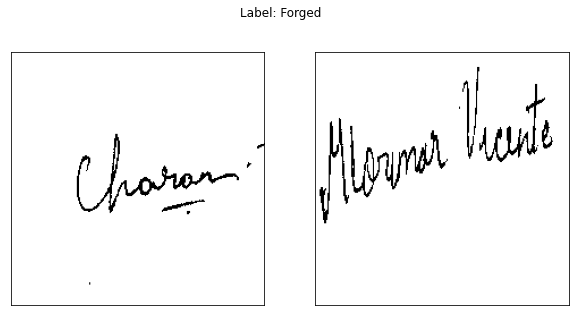

In [11]:
visualize_sample(preprocessed_datasets['test'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10


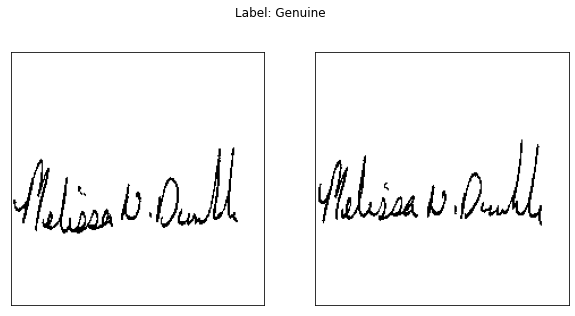

In [12]:
visualize_sample(preprocessed_datasets['test'])

## Modeling

In [13]:
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))
  

import tensorflow.keras.backend as K

def contrastive_loss_new(y_true, y_pred, margin=0.5):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    y_true = tf.cast(y_true, y_pred.dtype)
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

def get_embedding_model(input_shape = (224, 224, 3)):

    # base_cnn = resnet50.ResNet50(
    #     weights="imagenet", input_shape=input_shape, include_top=False
    # )

    base_cnn = vgg16.VGG16(
        weights="imagenet", input_shape=input_shape, include_top=False
    )

    base_cnn.trainable = False

    x = layers.GlobalAveragePooling2D()(base_cnn.output)
    x = layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01))(x)
    x = layers.Dropout(0.4)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128)(x)
    x = layers.Lambda(lambda y: tf.math.l2_normalize(y, axis=1))(x) # L2 normalize embeddings

    embedding_network = keras.Model(base_cnn.input, x, name="Embedding_Model")

    return embedding_network


def get_siamese_model(input_shape = (224, 224, 3)):

    embedding_network = get_embedding_model(input_shape)

    input_1 = layers.Input(input_shape, name='input1')
    input_2 = layers.Input(input_shape, name='input2')

    embed_1 = embedding_network(input_1)
    embed_2 = embedding_network(input_2)

    distance_layer = layers.Lambda(euclidean_distance, name='distance_layer')([embed_1, embed_2])
    siamese = keras.Model(inputs=[input_1, input_2], outputs=distance_layer, name='siamese_network')

    return siamese

def get_compiled_model():
  siamese = get_siamese_model()
  siamese.compile(
                  loss= contrastive_loss_new,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
  
  return siamese


def plot_history(history, title=""): 
   
  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Losss | ' + title)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')

  
  plt.show()


In [14]:
import os

# Prepare a directory to store all the checkpoints.
checkpoint_dir = "/content/gdrive/MyDrive/FF20_SignVer/models"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

def make_or_restore_model(checkpoint_filepath):
  # Either restore the latest model, or create a fresh one
  # if there is no checkpoint available.

  if os.path.exists(os.path.dirname(checkpoint_filepath)):
      print("Restoring from", checkpoint_filepath)
      # return keras.models.load_model(latest_checkpoint, custom_objects={'distance': SiameseNetwork().euclidean_distance})
      model = get_compiled_model()
      model.load_weights(checkpoint_filepath)
      return model
  print("Creating a new model")
  return get_compiled_model()

In [15]:
# del siamese
dir_name = 'contrastive_fixedloss_sm128_2layer_wdo_m05_wunskilled_vgg'
model_dir = os.path.join(checkpoint_dir, )
checkpoint_filepath = os.path.join(checkpoint_dir, dir_name, 'training.ckpt')
tensorboard_logdir = os.path.join(checkpoint_dir, dir_name, 'logs')
siamese = make_or_restore_model(checkpoint_filepath)

Restoring from /content/gdrive/MyDrive/FF20_SignVer/models/contrastive_fixedloss_sm128_2layer_wdo_m05_wunskilled_vgg/training.ckpt
58892288/58889256 [==============================] - 0s 0us/step


In [16]:
siamese.summary()

Model: "siamese_network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Embedding_Model (Functional)    (None, 128)          14797376    input1[0][0]                     
                                                                 input2[0][0]                     
__________________________________________________________________________________________________
distance_layer (Lambda)         (None, 1)            0           Embedding_Model[0][

In [ ]:
%%time

import math
initial_learning_rate = 0.0005
def lr_exp_decay(epoch, lr):
    k = 0.1
    return initial_learning_rate * math.exp(-k*epoch)


callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        save_weights_only=True,
        monitor="val_loss",
        verbose=1,
    ),
   keras.callbacks.TensorBoard(log_dir=tensorboard_logdir, update_freq='batch'),
   keras.callbacks.LearningRateScheduler(lr_exp_decay, verbose=1)
  #  keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
  #                                     patience=4, min_lr=0.0001),
]


siamese.fit(
    x=preprocessed_datasets["train"],
    validation_data=preprocessed_datasets["test"],
    # batch_size=batch_size,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0005.
570/570 [==============================] - 501s 860ms/step - loss: 0.4858 - val_loss: 0.1275

Epoch 00001: val_loss improved from inf to 0.12751, saving model to /content/gdrive/MyDrive/FF20_SignVer/models/contrastive_fixedloss_sm128_2layer_wdo_m05_wunskilled_vgg/training.ckpt
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00045241870901797975.
570/570 [==============================] - 481s 843ms/step - loss: 0.0787 - val_loss: 0.0649

Epoch 00002: val_loss improved from 0.12751 to 0.06486, saving model to /content/gdrive/MyDrive/FF20_SignVer/models/contrastive_fixedloss_sm128_2layer_wdo_m05_wunskilled_vgg/training.ckpt
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0004093653765389909.
570/570 [==============================] - 481s 844ms/step - loss: 0.0519 - val_loss: 0.0511

Epoch 00003: val_loss improved from 0.06486 to 0.05108, saving model to 

In [ ]:
model_path = f'/content/gdrive/MyDrive/FF20_SignVer/models/{dir_name}/actual_model'

os.makedirs(model_path, exist_ok=True)
# siamese.save(model_path)

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/FF20_SignVer/models/contrastive_fixedloss_sm128_2layer_wdo_m25/actual_model/assets


In [ ]:
def visualize_prediction(dataset, model):

    imgs, label = list(dataset.take(1).as_numpy_iterator())[0]
    img1_batch, img2_batch, label_batch = *imgs, label

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # select random image from batch
    idx = np.random.choice(range(len(img1_batch)))
    print(idx)

    pred = model.predict((np.expand_dims(img1_batch[idx], 0), np.expand_dims(img2_batch[idx],0)))

    for i, img_batch in enumerate([img1_batch, img2_batch]):

        ax[i].imshow(img_batch[idx])
        ax[i].get_xaxis().set_visible(False)
        ax[i].get_yaxis().set_visible(False)

    label_lookup = {0: "Forged",
                    1: "Genuine",
                    2: "Unskilled Forged"}

    fig.suptitle(f"Label: {label_lookup[label_batch[idx]]} ({label_batch[idx]}) - Pred: {pred}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


49


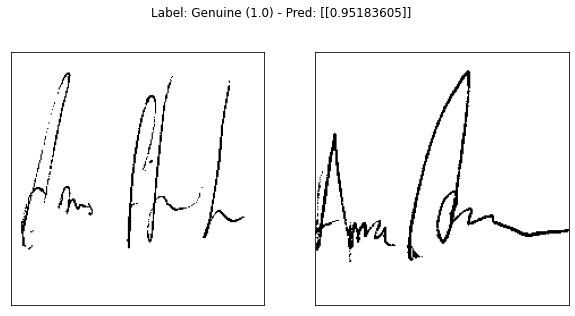

In [ ]:
visualize_prediction(preprocessed_datasets['test'], siamese)

In [ ]:

%load_ext tensorboard
%tensorboard --logdir /content/gdrive/MyDrive/FF20_SignVer/models/{dir_name}/logs

## Plot UMAP Embeddings

In [ ]:
!pip3 install umap-learn

import umap
import plotly.express as px

In [ ]:
checkpoint_filepath

'/content/gdrive/MyDrive/FF20_SignVer/models/contrastive_fixedloss_sm128_2layer_wdo_m05/training.ckpt'

In [ ]:

# model = keras.models.load_model('/content/gdrive/MyDrive/FF20_SignVer/models/{dir_name}/actual_model',
#                                 custom_objects={'contrastive_loss_new2':contrastive_loss_new2})

# siamese = make_or_restore_model(checkpoint_filepath)
# model = tf.saved_model.load(f'/content/gdrive/MyDrive/FF20_SignVer/models/{dir_name}/actual_model')


embedding_model = keras.Model(siamese.get_layer("Embedding_Model").input, siamese.get_layer("Embedding_Model").output)

In [ ]:
def get_embedding(img_array, model):

    # if grayscale, replicate intensity values to have 3 channels (gray-->RGB)
    if img_array.shape[-1] != 3:
        img_array = np.stack((img_array.squeeze(),) * 3, axis=-1)

    img_array = np.expand_dims(img_array, axis=0)
    block_features = model.predict(img_array)

    return block_features

In [ ]:
%%time

# train_authors = cedar_dataset.image_metadata[cedar_dataset.image_metadata.train_test=='train'].author.unique()
# embeddings = cedar_dataset.image_metadata[cedar_dataset.image_metadata.author.isin(train_authors)].image_path.apply(lambda x: get_embedding(preprocess_image(x), embedding_model))

embeddings = cedar_dataset.image_metadata.image_path.apply(lambda x: get_embedding(preprocess_image(x), embedding_model))
embeddings = np.squeeze(np.stack(embeddings, axis=1))

CPU times: user 2min 25s, sys: 6.21 s, total: 2min 32s
Wall time: 2min 23s


In [ ]:
%%time 

reducer = umap.UMAP(n_neighbors=15, n_components=2, metric="euclidean")
embedding_umap = reducer.fit_transform(embeddings)

CPU times: user 21.4 s, sys: 650 ms, total: 22.1 s
Wall time: 11.9 s


In [ ]:
fig = px.scatter(
    x=embedding_umap[:, 0],
    y=embedding_umap[:, 1],
    color=cedar_dataset.image_metadata.author.astype("str"),
    hover_name=cedar_dataset.image_metadata.sig_number,
    symbol=cedar_dataset.image_metadata.label,
    width=1400,
    height=1000,
    title="UMAP Embedding Projection - Cosine",
)
fig.show()

In [ ]:
# train only

fig = px.scatter(
    x=embedding_umap[:, 0],
    y=embedding_umap[:, 1],
    color=cedar_dataset.image_metadata[cedar_dataset.image_metadata.author.isin(train_authors)].author.astype("str"),
    hover_name=cedar_dataset.image_metadata[cedar_dataset.image_metadata.author.isin(train_authors)].sig_number,
    symbol=cedar_dataset.image_metadata[cedar_dataset.image_metadata.author.isin(train_authors)].label,
    width=1400,
    height=1000,
    title="UMAP Embedding Projection - Cosine",
)
fig.show()

## Characterize Performance

In [ ]:
from scipy import spatial
from sklearn.metrics import roc_curve

In [ ]:
checkpoint_filepath = os.path.join(checkpoint_dir, dir_name, 'training.ckpt')
siamese = make_or_restore_model(checkpoint_filepath)

Restoring from /content/gdrive/MyDrive/FF20_SignVer/models/contrastive_fixedloss_sm128_2layer_wdo_m25/training.ckpt


In [ ]:
def gather_validation_dataset(verification_pairs, image_metadata, idx_filename_mapping, test_type='both'):#nclude_unskilled=False, remove_skilled=False):
    """
    Given a dataframe of verification pairs for each author and mapping of index to filepaths,
    this function collects image pairs (filenames) and labels (int) and returns them as a
    nested tf.data.Dataset object.

    """
    authors = image_metadata[image_metadata.train_test == 'test'].author.unique()
    verification_pairs = verification_pairs[(cedar_dataset.verification_pairs.author.isin(authors))]

    if test_type == "skilled":
      verification_pairs = verification_pairs[(verification_pairs.label != 2)]
    elif test_type == "unskilled":
      verification_pairs = verification_pairs[(verification_pairs.label != 0)]
      verification_pairs.label = verification_pairs.label.apply(lambda x: x if x != 2 else 0)
    elif test_type == 'all':
      verification_pairs.label = verification_pairs.label.apply(lambda x: x if x != 2 else 0)



    x1 = (
        verification_pairs["anchor_idx"].apply(lambda x: idx_filename_mapping[x]).values
    )
    x2 = verification_pairs["alt_idx"].apply(lambda x: idx_filename_mapping[x]).values

    x1 = tf.data.Dataset.from_tensor_slices(x1)
    x2 = tf.data.Dataset.from_tensor_slices(x2)

    x1 = x1.map(lambda x: tf.py_function(func=preprocess_image, inp=[x], Tout=tf.float32))
    x2 = x2.map(lambda x: tf.py_function(func=preprocess_image, inp=[x], Tout=tf.float32))

    x1 = x1.batch(64, drop_remainder=False)
    x2 = x2.batch(64, drop_remainder=False)

    y_true = verification_pairs["label"]

    return x1, x2, y_true

In [ ]:
def calculate_test_distances(embed_model, verification_pairs, image_metadata, path_lookup, test_type, distance_metric=spatial.distance.cosine):


  x1, x2, y_true = gather_validation_dataset(verification_pairs, image_metadata, path_lookup, test_type)

  embed_1 = embed_model.predict(x1)
  embed_2 = embed_model.predict(x2)
  y_true = y_true.to_numpy()


  records = []
  for i in range(len(embed_1)):
    dist = round(distance_metric(embed_1[i], embed_2[i]), 4)

    record = (embed_1[i], embed_2[i], dist, y_true[i])

    records.append(record)

  return pd.DataFrame(records, columns=['embed_1', 'embed_2','distance', 'label'])

In [ ]:
embedding_model = keras.Model(siamese.get_layer("Embedding_Model").input, siamese.get_layer("Embedding_Model").output)

In [ ]:
%%time

records = calculate_test_distances(embedding_model,
                                   cedar_dataset.verification_pairs,
                                   cedar_dataset.image_metadata,
                                   cedar_dataset.img_path_lookup,
                                   test_type='unskilled',
                                   distance_metric=spatial.distance.cosine)

CPU times: user 1min 35s, sys: 5.11 s, total: 1min 40s
Wall time: 1min 31s


In [ ]:
fprs, tprs, thresholds = roc_curve(
    y_true=records.label, y_score=records.distance, pos_label=0
)

fnrs = 1 - tprs

Text(0, 0.5, 'True Positive Rate (TPR)')

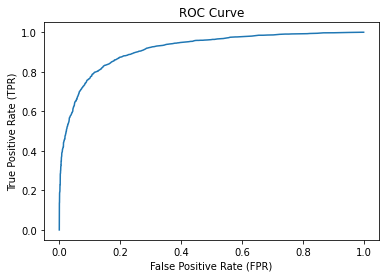

In [ ]:
plt.plot(fprs, tprs)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")

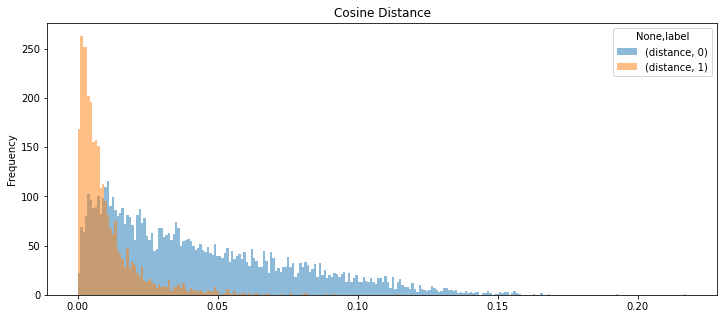

In [ ]:
records.pivot(columns='label').plot.hist(
    bins=250, alpha=0.5, title="Cosine Distance", figsize=(12, 5))

In [ ]:
def find_eer(fprs, tprs, thresholds):
    """
    Given a set of False Positive Rates, True Positive Rates, and corresponding thresholds output by
    sklearn.metrics.roc_curve(), calculate the Equal Error Rate (EER).

    EER (also known as Crossover Error Rate) is the point on the ROC curve where FPR==FNR.

    """
    fnrs = 1 - tprs

    crossover = np.argwhere(np.diff(np.sign(fprs - fnrs)))

    if len(crossover) > 1:
        crossover_idx = np.argwhere(np.diff(np.sign(fprs - fnrs)))[0].item()
    else:
        crossover_idx = np.argwhere(np.diff(np.sign(fprs - fnrs))).item()

    crossover_thresh = thresholds[crossover_idx]
    crossover_error = fnrs[crossover_idx]

    return crossover_idx, crossover_thresh, crossover_error

In [ ]:
crossover_idx, crossover_thresh, crossover_error = find_eer(fprs, tprs, thresholds)

In [ ]:
def find_max_accuracy(fprs, tprs, thresholds):

    accs = []

    for fpr, tpr, thresh in list(zip(fprs, tprs, thresholds)):

        accuracy = 0.5 * (tpr + (1 - fpr))  # tnr = (1-fpr)
        accs.append(accuracy)

    max_acc_idx = np.argmax(accs)

    return accs[max_acc_idx]

In [ ]:
def get_metrics(fprs, tprs, thresholds):

  crossover_idx, crossover_thresh, crossover_error = find_eer(fprs, tprs, thresholds)
  max_accuracy = find_max_accuracy(fprs, tprs, thresholds)

  return {'crossover_idx': crossover_idx,
          'crossover_thresh': crossover_thresh,
          'crossover_error': crossover_error,
          'max_accuracy': max_accuracy}


In [ ]:
get_metrics(fprs, tprs, thresholds)

{'crossover_error': 0.22233201581027673,
 'crossover_idx': 915,
 'crossover_thresh': 0.0135,
 'max_accuracy': 0.7823616600790514}

In [ ]:
def plot_threshold_curves(fprs, fnrs, crossover_error, crossover_thresh):
    """
    Plot two curves and visualized the Equal Error Rate.

    EER (also known as Crossover Error Rate) is the point on the ROC curve where FPR==FNR.

    """

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # plot rate vs. distance
    axs[0].plot(thresholds[1:], fprs[1:], label="False Positive Rate (FPR)")
    axs[0].plot(thresholds[1:], fnrs[1:], label="False Negative Rate (FNR)")
    axs[0].plot(crossover_thresh, crossover_error, "o")
    axs[0].set(xlabel="Distance Threshold")
    axs[0].set(ylabel="Rate (%)")
    axs[0].set_title("Failure Rates vs. Distance Threshold")
    axs[0].legend()

    # plot ROC curve
    axs[1].plot(fprs, tprs)
    axs[1].plot((1, 0), (0, 1))
    axs[1].plot(crossover_error, (1 - crossover_error), "o")
    axs[1].set(xlabel="False Positive Rate (FPR)")
    axs[1].set(ylabel="True Positive Rate (TPR)")
    axs[1].set_title("ROC Curve")

    plt.tight_layout()

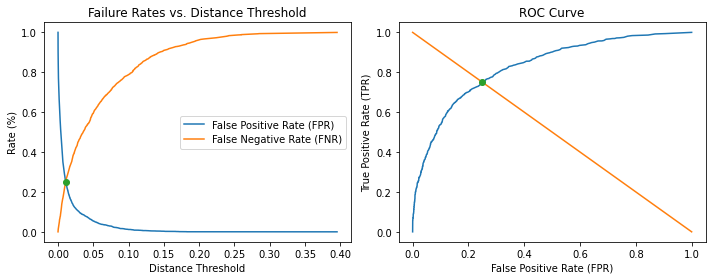

In [ ]:
plot_threshold_curves(fprs, fnrs, crossover_error, crossover_thresh)